In [13]:
import torch
from map_action_tranform import get_transform
from map_action_data_loader import map_action_test_data_loader, map_action_test_dataset 
from m_a_detection_model import map_action_instance_segmentation_model
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, accuracy_score, average_precision_score
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Function to calculate IoU
def calculate_iou(pred_boxes, true_boxes):
    x1 = torch.max(pred_boxes[:, 0], true_boxes[:, 0])
    y1 = torch.max(pred_boxes[:, 1], true_boxes[:, 1])
    x2 = torch.min(pred_boxes[:, 2], true_boxes[:, 2])
    y2 = torch.min(pred_boxes[:, 3], true_boxes[:, 3])

    intersection = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)
    area_pred = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
    area_true = (true_boxes[:, 2] - true_boxes[:, 0]) * (true_boxes[:, 3] - true_boxes[:, 1])
    union = area_pred + area_true - intersection

    iou = intersection / union
    return iou

In [ ]:
import torch
import numpy as np
from sklearn.metrics import average_precision_score, accuracy_score, precision_score, precision_recall_curve
import matplotlib.pyplot as plt

def test_model(model, test_loader, device):
    model.eval()

    all_pred_boxes = []
    all_true_boxes = []

    for images, targets in test_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            outputs = model(images)

        for output, target in zip(outputs, targets):
            pred_boxes = output['boxes'].cpu()
            true_boxes = target['boxes'].cpu()
            all_pred_boxes.append(pred_boxes)
            all_true_boxes.append(true_boxes)

    all_pred_boxes = torch.cat(all_pred_boxes, dim=0)
    all_true_boxes = torch.cat(all_true_boxes, dim=0)

    ious = calculate_iou(all_pred_boxes, all_true_boxes)
    average_precision = average_precision_score(np.ones(len(ious)), ious)

    # Threshold for considering a detection correct
    detection_threshold = 0.5
    pred_labels = (ious > detection_threshold).float()

    true_labels = torch.ones(len(all_true_boxes), dtype=torch.float32)

    true_labels_np = np.concatenate([np.zeros(len(true_labels_np) // 2), np.ones(len(true_labels_np) // 2)])

    # Ensure that both arrays have the same length
    min_length = min(len(true_labels_np), len(pred_labels_np))
    true_labels_np = true_labels_np[:min_length]
    pred_labels_np = pred_labels_np[:min_length]

    accuracy = accuracy_score(true_labels_np, pred_labels_np)
    precision = precision_score(true_labels_np, pred_labels_np)

    print(f'Mean Average Precision (mAP): {average_precision:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')

    # Plotting precision-recall curve
    precision, recall, _ = precision_recall_curve(true_labels_np, ious)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

In [14]:
root_dir_test = 'C:\\Users\\Wakfu\\Downloads\\Compressed\\project-6-at-2023-11-29-00-47-1b67ac6d\\'
annotation_file_test = 'C:\\Users\\Wakfu\\Downloads\\Compressed\\project-6-at-2023-11-29-00-47-1b67ac6d\\result.json'

# Load the pre-trained model
model_path = 'C:\\Users\\Wakfu\\OneDrive\\Documents\\map-action\\Map-Action-Model\\model\\MAISM1.pth'
model = map_action_instance_segmentation_model(3)  # Initialize your model architecture
model.load_state_dict(torch.load(model_path))
model.eval()

# Create the testing dataset
test_transform = get_transform
test_dataset = map_action_test_dataset
  # Replace with your class names

# Create a data loader for testing
test_loader = map_action_test_data_loader

"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

test_model(model, test_loader, device)"""


"\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\nmodel.to(device)\nprint(device)\n\ntest_model(model, test_loader, device)"

In [15]:
import numpy as np

def extract_predictions(model_output):
    predictions = []
    for prediction in model_output:
        pred_dict = {
            'boxes': prediction['boxes'].detach().cpu().numpy(),
            'labels': prediction['labels'].detach().cpu().numpy(),
            'scores': prediction['scores'].detach().cpu().numpy(),
        }
        predictions.append(pred_dict)
    return predictions


In [16]:
all_predictions = []
all_targets = []

with torch.no_grad():
    for images, targets in test_loader:
        images = list(image.to('cpu') for image in images)
        targets = [{k: v.to('cpu') for k, v in t.items()} for t in targets]

        outputs = model(images)

        # Assuming you have a function to extract bounding boxes, labels, and scores from the model output
        predictions = extract_predictions(outputs)

        all_predictions.extend(predictions)
        all_targets.extend(targets)

# Calculate metrics
# You can use your own functions or external libraries like scikit-learn to calculate metrics
# Example: calculate precision, recall, and f1 score
from sklearn.metrics import precision_score, recall_score, f1_score

# Extract ground truth labels and predicted labels
true_labels = [t['labels'] for t in all_targets]
predicted_labels = [p['labels'] for p in all_predictions]

# Flatten the lists
true_labels = [item for sublist in true_labels for item in sublist]
predicted_labels = [item for sublist in predicted_labels for item in sublist]

# Ensure the lengths match
min_length = min(len(true_labels), len(predicted_labels))
true_labels = true_labels[:min_length]
predicted_labels = predicted_labels[:min_length]

# Calculate precision, recall, and f1 score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

C:\Users\Wakfu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.2500
Recall: 0.5000
F1 Score: 0.3333


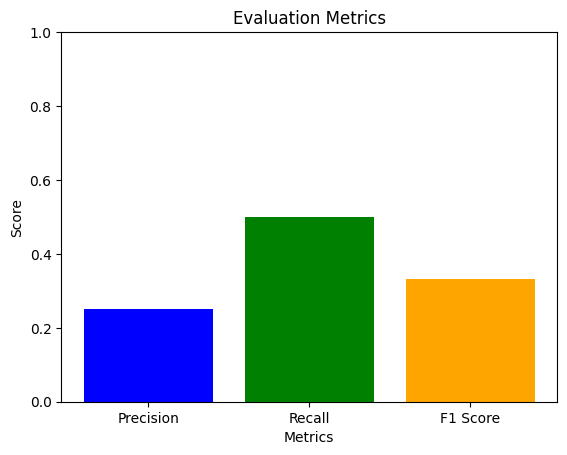

In [18]:
import matplotlib.pyplot as plt

labels = ['Precision', 'Recall', 'F1 Score']
scores = [precision, recall, f1]

plt.bar(labels, scores, color=['blue', 'green', 'orange'])
plt.ylim(0, 1)  # Set the y-axis limit between 0 and 1 for scores
plt.title('Evaluation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.show()

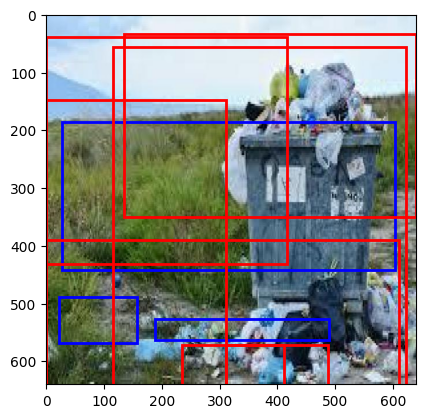

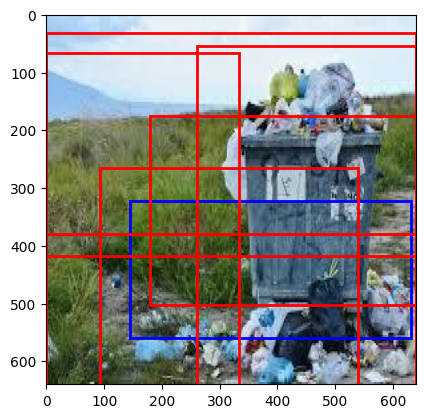

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def plot_prediction(image, target, predictions):
    img = Image.open(image)

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Plot ground truth bounding boxes
    for box in target['boxes']:
        x, y, w, h = box.tolist()
        rect = patches.Rectangle((x, y), w - x, h - y, linewidth=2, edgecolor='b', facecolor='none')
        ax.add_patch(rect)

    # Plot predicted bounding boxes
    for box in predictions['boxes']:
        x, y, w, h = box.tolist()
        rect = patches.Rectangle((x, y), w - x, h - y, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Assuming `test_loader` is your DataLoader for the test dataset
for images, targets in test_loader:
    # Move images and targets to the device used for training
    images = list(img.to('cpu') for img in images)
    targets = [{k: v.to('cpu') for k, v in t.items()} for t in targets]

    # Make predictions
    predictions = model(images)

    # Assuming you want to visualize the first image in the batch
    image_path = "C:\\Users\\Wakfu\\Downloads\\Compressed\\project-6-at-2023-11-29-00-47-1b67ac6d\\images\\dumpgarbage150_jpeg.rf.9e011cffb9876772f0911e765ebd0e55.jpg"
    plot_prediction(image_path, targets[0], predictions[0])


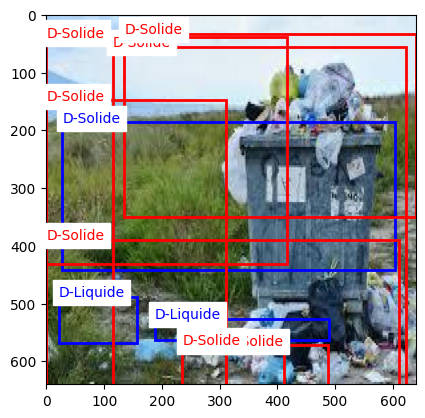

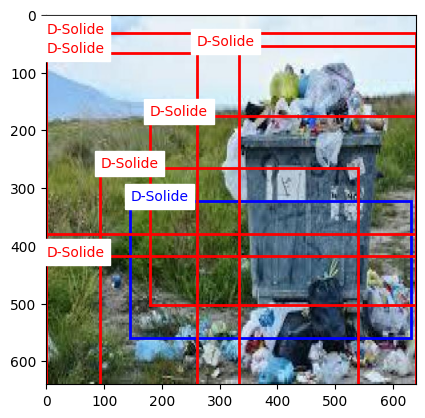

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def plot_prediction(image, target, predictions, classes):
    img = Image.open(image)

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Plot ground truth bounding boxes with labels
    for box, label in zip(target['boxes'], target['labels']):
        x, y, w, h = box.tolist()
        rect = patches.Rectangle((x, y), w - x, h - y, linewidth=2, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, classes[label], color='b', backgroundcolor='w')

    # Plot predicted bounding boxes with labels
    for box, label in zip(predictions['boxes'], predictions['labels']):
        x, y, w, h = box.tolist()
        rect = patches.Rectangle((x, y), w - x, h - y, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, classes[label], color='r', backgroundcolor='w')

    plt.show()

# Assuming `test_loader` is your DataLoader for the test dataset
for images, targets in test_loader:
    # Move images and targets to the device used for training
    images = list(img.to('cpu') for img in images)
    targets = [{k: v.to('cpu') for k, v in t.items()} for t in targets]

    # Make predictions
    predictions = model(images)

    # Assuming you want to visualize the first image in the batch
    image_path = "C:\\Users\\Wakfu\\Downloads\\Compressed\\project-6-at-2023-11-29-00-47-1b67ac6d\\images\\dumpgarbage150_jpeg.rf.9e011cffb9876772f0911e765ebd0e55.jpg"
    
    # Replace classes with the actual list of class names in your dataset
    class_names = ["D-Liquide", "D-Solide"]
    
    plot_prediction(image_path, targets[0], predictions[0], classes=class_names)
